# Amazon Rekogniton Demo

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<img src="resources/Slide1.png">

<img src="resources/Slide2.png">

<img src="resources/Slide3.png">

In [9]:
# initialise Notebook
import imageio
imageio.plugins.ffmpeg.download()
import boto3
from IPython.display import HTML, display
from PIL import Image, ImageDraw, ImageFont
from pprint import pprint
from io import BytesIO
import numpy as np
import moviepy.editor as mpy
import os
import uuid
import io
import tabulate
import requests

YOUR_ACCESS_KEY='##########'
YOUR_SECRET_KEY='###############################'

# key variable initiation
rekognition = boto3.client('rekognition', region_name='us-west-2',
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)
dynamodb = boto3.resource('dynamodb', region_name='us-west-2',
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)
s3 = boto3.client('s3', region_name='us-west-2',
                           aws_access_key_id=YOUR_ACCESS_KEY,aws_secret_access_key=YOUR_SECRET_KEY)

# blue, green, red, grey
colors = ((220,220,220),(242,168,73),(76,182,252),(52,194,123))

# helper function to lookup names in dynamoDB
actors = dynamodb.Table('rekognition_actors')
def get_actor_name(actorId):
    response = actors.get_item(
            Key={
                'actorId': actorId
            },
            AttributesToGet=['actorFullName']                  
        )
    
    if 'Item' in response:
        return (response['Item']['actorFullName'])
    else:
        return ('no match found in actors lookup')
    
# Detect face boxes using Rekognition

def face_detection(image_input):
    response = rekognition.detect_faces(
        Image={
            'Bytes':image_input
        }                                        
        )
    
    all_faces=response['FaceDetails']
    
    # initialise list object 
    boxes = []
  
    # populate list for each face
    for face in all_faces:
        boxes.append (face['BoundingBox'])
    return boxes

# apply face boxes to image and store coordinates for later processing
def get_coordinates(face_boxes, image_width, image_height):
    # initialise list object 
    coordinates = [] 
    for box in face_boxes:
        x1 = int(box['Left'] * image_width)-5
        y1 = int(box['Top'] * image_height)-5
        x2 = int(box['Left'] * image_width + box['Width'] * image_width)+5
        y2 = int(box['Top'] * image_height + box['Height']  * image_height)+5
        if x1 < 0 : x1=0
        if y1 < 0 : y1=0
        if x2 < 0 : x2=image_width
        if y2 < 0 : y2=image_height 
            
        coordinates.append((x1,y1,x2,y2))
        
    return coordinates

# Search faces in index

def get_face_data(image_binary):
    
    try:
        response = rekognition.search_faces_by_image(
            CollectionId='actors',
            Image={
                'Bytes':image_binary
            }                                       
            )
    
        if len(response['FaceMatches']) > 0:
            for o in response['FaceMatches']:
                print (o['Face']['FaceId'],o['Face']['Confidence'],get_actor_name(o['Face']['FaceId']))
            return response['FaceMatches'][0]['Face']['FaceId'],response['FaceMatches'][0]['Face']['Confidence']
        else:
            return ('no match detected',0)
    except Exception as e:
        #print (e)
        return ('no face detected',0)

frame_actors = []
all_actors =[]

def get_Faces(image_path):
    # load image into byte stream
    image_bin=Image.open(image_path)
    stream = io.BytesIO()
    image_bin.save(stream,format="JPEG")
    image_binary = stream.getvalue()
    
    # Detect face boxes using Rekognition
    boxes = face_detection(image_binary)
    width, height = image_bin.size
    xys = get_coordinates(boxes,width, height)
    
    # iterate through list of boxes and detect individual face
    # initialise list object 
    ret = []
    for box in xys:
           
        image_crop = image_bin.crop(box)
        
        # add cropped image to temporary stream
        stream2 = io.BytesIO() 
        image_crop.save(stream2,format="JPEG")
        image_region_binary = stream2.getvalue()    
        stream2.close()
        
        try:
            # get external ID name of cropped image
            retdata=get_face_data(image_region_binary),box
            ret.append (get_actor_name(retdata[0][0]))  
            all_actors.append(get_actor_name(retdata[0][0]))
        except Exception as e:
            ret.append ((('no face',0),box))
            pass
    
    frame_actors.append((ret))
    

In [6]:
%%bash
aws rekognition create-collection --collection-id actors --region us-west-2

bash: line 1: aws: command not found


In [3]:
# load face definitions into index

faces = [
#{"objectId":"Analysis/z5oj3dys.jpg","actorFullName":"Alexandra Maria Lara"},
#{"objectId":"Analysis/z6od3gys.jpg","actorFullName":"Alexandra Maria Lara"},
    #{"objectId":"ndtv/lionel-messi-1.jpg","actorFullName":"Lionel Messi"},
    #{"objectId":"ndtv/lionel-messi-2.jpg","actorFullName":"Lionel Messi"},
    #{"objectId":"ndtv/lionel-messi-3.jpg","actorFullName":"Lionel Messi"},
    #{"objectId":"ndtv/lionel-messi-4.jpg","actorFullName":"Lionel Messi"},
    #{"objectId":"ndtv/lionel-messi-5.jpg","actorFullName":"Lionel Messi"},
    #{"objectId":"ndtv/aishwarya-4.jpg","actorFullName":"Aishwarya Rai"},
    #{"objectId":"ndtv/aishwarya-5.jpg","actorFullName":"Aishwarya Rai"},
    #{"objectId":"ndtv/aishwarya-6.jpg","actorFullName":"Aishwarya Rai"},    
    #{"objectId":"ndtv/kat-1.jpeg","actorFullName":"Katrina Kaif"},
    #{"objectId":"ndtv/kat-2.jpg","actorFullName":"Katrina Kaif"},
    #{"objectId":"ndtv/kat-3.jpg","actorFullName":"Katrina Kaif"},    
    #{"objectId":"ndtv/sudhmita-2.jpg","actorFullName":"Sushmita Sen"},    
    #{"objectId":"ndtv/sushmita-3.jpg","actorFullName":"Sushmita Sen"},    
]

s3_image_bucket = 'ai-demo-in'
face_table = dynamodb.Table('rekognition_actors')

# function to write reference table in DynamoDB
def populate_lookup_table(actorFullName,actorId):
    print ('Populating DynamoDB index for ' + actorFullName + ' as ' + actorId)
    response = face_table.put_item(
                Item={
                      'actorId': actorId,
                      'actorFullName': actorFullName,
                      }
                )
    return response
        
def populate_rekognition_collection(objectId):
    print ('Indexing ', objectId)
    ret = rekognition.index_faces(
    CollectionId=rekognition_face_index,
    Image={
                'S3Object': {
                    'Bucket': s3_image_bucket,
                    'Name':  objectId
                }
            }
        )
    if ret['ResponseMetadata']['HTTPStatusCode'] == 200:
        return ret['FaceRecords'][0]['Face']['FaceId']
    else:
        return False
    

# function to populate faces into index
def populate_index(all_faces,rekognition_face_index):
    for f in all_faces:
        ret = populate_rekognition_collection(f['objectId'])
        if ret == False:
            print ('some error')
        else:
            ret = populate_lookup_table(f['actorFullName'],ret)
            pprint (ret['ResponseMetadata']['HTTPStatusCode'])
        
              
    print ('done')



    
rekognition_face_index = 'actors' 
populate_index(faces,rekognition_face_index)

done


# Finding Objects from Images

Using Amazon DetectLabels API, you can detect objects in an image along with a confidence score for those objects.

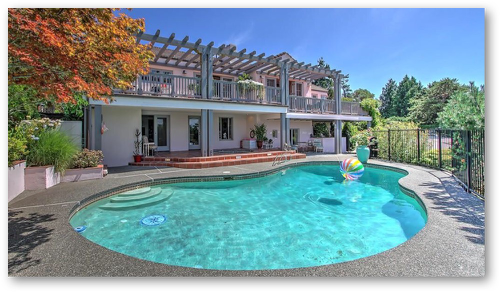

[{u'Confidence': 98.59609985351562, u'Name': u'Building'},
 {u'Confidence': 98.59609985351562, u'Name': u'House'},
 {u'Confidence': 98.59609985351562, u'Name': u'Housing'},
 {u'Confidence': 98.59609985351562, u'Name': u'Villa'},
 {u'Confidence': 92.94024658203125, u'Name': u'Pool'},
 {u'Confidence': 92.94024658203125, u'Name': u'Water'},
 {u'Confidence': 76.87645721435547, u'Name': u'Garden'},
 {u'Confidence': 76.87645721435547, u'Name': u'Outdoors'},
 {u'Confidence': 72.41119384765625, u'Name': u'Flora'},
 {u'Confidence': 72.41119384765625, u'Name': u'Jar'},
 {u'Confidence': 72.41119384765625, u'Name': u'Plant'},
 {u'Confidence': 72.41119384765625, u'Name': u'Planter'},
 {u'Confidence': 72.41119384765625, u'Name': u'Potted Plant'},
 {u'Confidence': 72.41119384765625, u'Name': u'Pottery'},
 {u'Confidence': 72.41119384765625, u'Name': u'Vase'},
 {u'Confidence': 69.56842803955078, u'Name': u'Hotel'},
 {u'Confidence': 69.56842803955078, u'Name': u'Resort'},
 {u'Confidence': 69.56842803955

In [4]:
#bucket = 'cppictures'
#key = 'NZ20tens/P1010138.JPG'
#key = 'NZ20tens/P4050012.JPG'
bucket = 'ai-demo-in'
#key = 'sample_iamges/parking-1.jpg'
#key = 'sample_iamges/city_road-1.jpg'
#key = 'sample_iamges/rafting.jpg'
key = 'sample_iamges/outdoor-pool.jpg'

# retrieve labels from Rekognition service
ret = rekognition.detect_labels(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    MaxLabels=20,
    #MinConfidence=85
)

# Output image and labels
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)
size = 500,500
image_bin=Image.open(image_location)
image_bin.thumbnail(size, Image.ANTIALIAS)

display(image_bin)

pprint(ret['Labels'])


<img src="resources/Slide4.png">

## Facial analysis

Using Amazon DetectFaces API, you can detect faces in an image and key facial characteristics.

As faces are detected on an image you get a number of attributes about the face:

	- gender
	- age
	- sentiment of the person
    - coordinates of key features
    - image quality
    - etc.


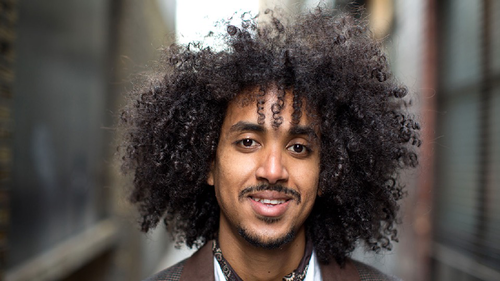

[{u'AgeRange': {u'High': 52, u'Low': 35},
  u'Beard': {u'Confidence': 99.95638275146484, u'Value': True},
  u'BoundingBox': {u'Height': 0.5592592358589172,
                   u'Left': 0.38269031047821045,
                   u'Top': 0.2925925850868225,
                   u'Width': 0.3149113655090332},
  u'Confidence': 99.98723602294922,
  u'Emotions': [{u'Confidence': 88.79723358154297, u'Type': u'HAPPY'},
                {u'Confidence': 1.2311756610870361, u'Type': u'SAD'},
                {u'Confidence': 0.8679866790771484, u'Type': u'ANGRY'}],
  u'Eyeglasses': {u'Confidence': 99.9994125366211, u'Value': False},
  u'EyesOpen': {u'Confidence': 98.68732452392578, u'Value': True},
  u'Gender': {u'Confidence': 90.34817504882812, u'Value': u'Male'},
  u'Landmarks': [{u'Type': u'eyeLeft',
                  u'X': 0.4958204925060272,
                  u'Y': 0.5077462196350098},
                 {u'Type': u'eyeRight',
                  u'X': 0.5964617729187012,
                  u'Y': 0.528584

In [5]:
bucket = 'ai-demo-in'
#key = 'Analysis/Werner_Vogels.jpeg'
key = 'sample_iamges/face.jpg'
#key = 'sample_iamges/grp3.jpg'
#key = 'sample_iamges/Test Pitch-34.jpg'


# detect faces using Rekognition service
ret = rekognition.detect_faces(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    Attributes=['ALL'],
)

# Output image and labels
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)
size = 500,500
image_bin=Image.open(image_location)
image_bin.thumbnail(size, Image.ANTIALIAS)

display(image_bin)

# Output labels

pprint (ret['FaceDetails'])


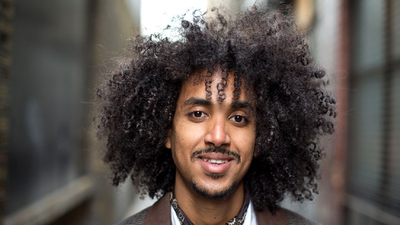

In [6]:
# retrieve and resize image for display

# Output image and labels
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)
size = 400,400
image_bin=Image.open(image_location)
image_bin.thumbnail(size, Image.ANTIALIAS)

display(image_bin)


# Detect Multiple Faces and Identify them

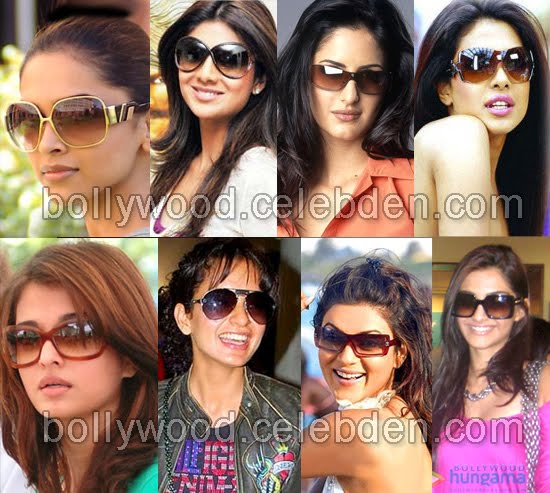

In [7]:


bucket = 'ai-demo-in'
key = 'ndtv/faces.png'
#key = 'sample_iamges/grp3.jpg'

    
# donwload image from S3
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)

image_out = Image.open("/tmp/image")
display(image_out)
    

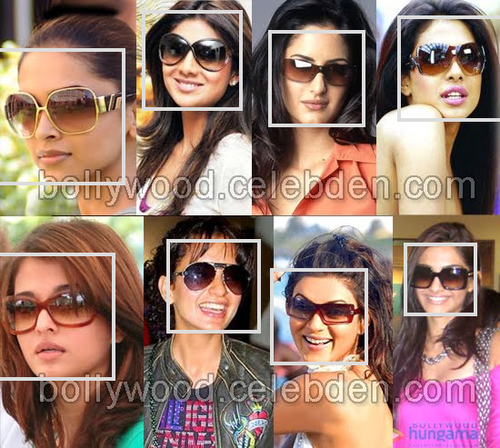

In [8]:
# retrieve face boxes from Rekognition service

ret = rekognition.detect_faces(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    Attributes=['DEFAULT'],
)

boxes = []

# Output labels
faces = ret['FaceDetails']
for face in faces:
    #pprint (face['BoundingBox'])
    boxes.append (face['BoundingBox'])

# apply face boxes to image 
draw = ImageDraw.Draw(image_out)
width, height = image_out.size
col = 0
line= 4
ind = 0
for box in boxes:
    if ind == 8:
        break
    ind = ind + 1 
#    print(box)
    x1 = int(box['Left'] * width)
    y1 = int(box['Top'] * height)
    x2 = int(box['Left'] * width + box['Width'] * width)
    y2 = int(box['Top'] * height + box['Height']  * height)
         
    for l in range(4):
        draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
        #print(l)
col += 1
size = 500,500
image_out.thumbnail(size, Image.ANTIALIAS)
   
display(image_out)


In [10]:
get_Faces("/tmp/image")
list = []

for i in frame_actors:
    file = i[0]
    actor_name = i[1]
    #print(file)
    #inner = "<table>"
    for actor_name in i[1]:
     #   inner += "<tr><td width='200'>" + actor_name + "</td></tr>"
        if actor_name != "no match found in actors lookup":
            print("The image features ", actor_name)
    #break 
    #inner += "</table>"
    #list.append(("<img src='" + file + "' height='200' width='100'>",inner))
    #if actor_name:
        #print("The image features ",actor_name)

(u'242af32a-0706-5949-a566-8bc080e00585', 99.9999008178711, u'Aishwarya Rai')
(u'35cb311c-bd76-5b8b-8520-979634ea6ce2', 99.99979400634766, u'Sushmita Sen')
(u'611bc9ec-0f4a-5e95-9f50-0331ef4dc833', 99.85070037841797, u'Katrina Kaif')
(u'e1e6cb61-5a9d-5c24-af67-837a6e5ddf74', 100.0, u'Katrina Kaif')
('The image features ', u'A')
('The image features ', u'i')
('The image features ', u's')
('The image features ', u'h')
('The image features ', u'w')
('The image features ', u'a')
('The image features ', u'r')
('The image features ', u'y')
('The image features ', u'a')
('The image features ', u' ')
('The image features ', u'R')
('The image features ', u'a')
('The image features ', u'i')


<img src="resources/Slide5.png">

## Content moderation

Provides image moderation to suggestive or explicit content that may not be appropriate for your audience based on two category and eight child category labels.

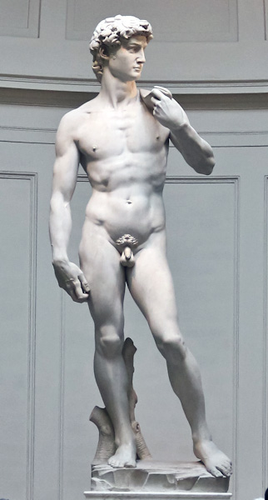

[{u'Confidence': 97.69403839111328,
  u'Name': u'Explicit Nudity',
  u'ParentName': u''},
 {u'Confidence': 97.69403839111328,
  u'Name': u'Nudity',
  u'ParentName': u'Explicit Nudity'}]


In [11]:
bucket = 'ai-demo-in'
key = 'ndtv/david-full-front.jpg'
#key = 'ndtv/david-pants.jpg'

# retrieve labels from Rekognition service
ret = rekognition.detect_moderation_labels(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    }
)

# Output image and labels
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)
size = 500,500
image_bin=Image.open(image_location)
image_bin.thumbnail(size, Image.ANTIALIAS)

display(image_bin)

pprint(ret['ModerationLabels'])


# Extracting Text from Images

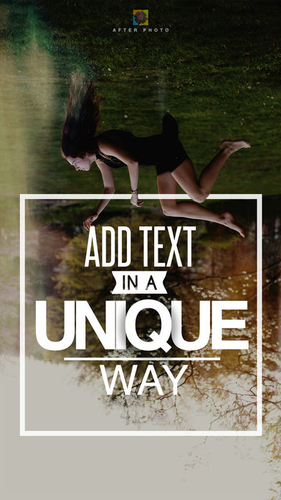

{u'Geometry': {u'BoundingBox': {u'Width': 0.41081205010414124, u'Top': 0.4429053068161011, u'Left': 0.287817120552063, u'Height': 0.09403085708618164}, u'Polygon': [{u'Y': 0.4429053068161011, u'X': 0.287817120552063}, {u'Y': 0.4409154951572418, u'X': 0.6986291408538818}, {u'Y': 0.5349463820457458, u'X': 0.7000648975372314}, {u'Y': 0.5369361639022827, u'X': 0.2892528772354126}]}, u'Confidence': 99.33494567871094, u'DetectedText': u'ADD TEXT', u'Type': u'LINE', u'Id': 0}
ADD TEXT
{u'Width': 0.41081205010414124, u'Top': 0.4429053068161011, u'Left': 0.287817120552063, u'Height': 0.09403085708618164}
IN A
{u'Width': 0.15711212158203125, u'Top': 0.5395049452781677, u'Left': 0.4144395589828491, u'Height': 0.042248599231243134}
UNIQUE
{u'Width': 0.7918227314949036, u'Top': 0.5873201489448547, u'Left': 0.10024756193161011, u'Height': 0.11399887502193451}
WAY
{u'Width': 0.3385959267616272, u'Top': 0.7185788154602051, u'Left': 0.3372485637664795, u'Height': 0.07492563873529434}
ADD
{u'Width': 0.1

In [12]:
bucket = 'ai-demo-in'
key = 'sample_iamges/textinimage.jpeg'
response = rekognition.detect_text(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    }
)

# Output image and labels
image_location = '/tmp/image'
s3.download_file(bucket, key, image_location)
size = 500,500
image_bin=Image.open(image_location)
image_bin.thumbnail(size, Image.ANTIALIAS)

display(image_bin)

text_detections = response['TextDetections']
print(text_detections[0])
for text in text_detections:
    print(text['DetectedText'])
    print(text['Geometry']['BoundingBox'])